In [1]:
%matplotlib inline

import pymongo
import seaborn as sns

In [2]:
import pandas as pd
import numpy as np

def group_by(df, bycols, agg_map):
    """

    @param df:      DataFrame
    @param bycols:  str or list
                        Column(s) to group by
    @param agg_map: dictionary or list of 2-tuples
                        Mapping from column to aggregate function e.g. [("city", "count"), ("salary", "mean"]
    @return:        DataFrame
                        Flattened dataframe, with multi-level index removed
    """
    grps = []
    if type(bycols) == str:
        bycols = [bycols]

    if type(agg_map) == dict:
        agg_map = agg_map.items()

    for k,v in agg_map:
        grp = df[bycols + [k]].groupby(bycols, ).agg(v)
        grp.reset_index(inplace=True)
        grp["%s(%s)" % (v,k)] = grp[k]
        del grp[k]
        grps.append(grp)

    m = grps[0]
    for grp in grps[1:]:
        m = pd.merge(m, grp, on=bycols, how="inner")
    return m

In [3]:
# NOTE - Turn off VPN when running pymongo
client = pymongo.MongoClient(port=27017)
db = client.metrics_causal_model

cb_td, cb_vd, sc_td, sc_vd = "CR_CB_SHIFT_REDUCE_PARSER_TEMPLATED_FEATURE_SEL_TD", "CR_CB_SHIFT_REDUCE_PARSER_TEMPLATED_FEATURE_SEL_VD", \
    "CR_SC_SHIFT_REDUCE_PARSER_TEMPLATED_FEATURE_SEL_TD", "CR_SC_SHIFT_REDUCE_PARSER_TEMPLATED_FEATURE_SEL_VD"
cb_td, cb_vd, sc_td, sc_vd = db[cb_td], db[cb_vd], db[sc_td], db[sc_vd]
cb_td, cb_vd, sc_td, sc_vd

(Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'metrics_causal_model'), 'CR_CB_SHIFT_REDUCE_PARSER_TEMPLATED_FEATURE_SEL_TD'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'metrics_causal_model'), 'CR_CB_SHIFT_REDUCE_PARSER_TEMPLATED_FEATURE_SEL_VD'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'metrics_causal_model'), 'CR_SC_SHIFT_REDUCE_PARSER_TEMPLATED_FEATURE_SEL_TD'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'metrics_causal_model'), 'CR_SC_SHIFT_REDUCE_PARSER_TEMPLATED_FEATURE_SEL_VD'))

# Query Top Features

In [4]:
from pprint import pprint
from bson.son import SON # needed to ensure dictionary is ordered (python default is not)

feats_pipeline = [{
    "$project": { 
            "weighted_f1_score":"$WEIGHTED_MEAN_CONCEPT_CODES.f1_score",
            "micro_f1_score":  "$MICRO_F1.f1_score",
            "micro_recall":    "$MICRO_F1.recall",
            "micro_precision": "$MICRO_F1.precision",
            "stemmed":        "$parameters.stemmed",
            "num_feats":      "$parameters.num_feats_MEAN",
            "feats":          "$parameters.extractors",
            "count": {        "$size" : "$parameters.extractors" },
            "asof" :          "$asof",
            "_id":1
    }
},
{
    "$match":{
        "micro_f1_score": { "$exists" : True },
        # how many feats
        #"count": {          "$eq" :1 },
        # window width
        #"window_size": {    "$eq":13 }
    }
},
{
    "$sort":{
        #"weighted_f1_score":-1,
        "micro_f1_score": -1
        #"asof": -1
        #"count": -1
    }
},
]

cb_td_rows = [row for row in cb_td.aggregate(feats_pipeline)]
cb_vd_rows = [row for row in cb_vd.aggregate(feats_pipeline)]
sc_td_rows = [row for row in sc_td.aggregate(feats_pipeline)]
sc_vd_rows = [row for row in sc_vd.aggregate(feats_pipeline)]

print(len(cb_td_rows), len(cb_vd_rows), len(sc_td_rows), len(sc_vd_rows))

13 13 10 10


In [5]:
def gbl_feats(fts):
    return [ft for ft in fts if ft.startswith("gbl")]

def hash_feats(fts):
    fts = gbl_feats(fts)
    return "|".join(sorted(fts))

def get_df_sorted_by_f1score(rows):
    df = pd.DataFrame(rows).sort_values("micro_f1_score", ascending=False)
    df["hs_feats"] = df["feats"].apply(hash_feats)
    return df

cb_td_df = get_df_sorted_by_f1score(cb_td_rows)
cb_vd_df = get_df_sorted_by_f1score(cb_vd_rows)
sc_td_df = get_df_sorted_by_f1score(sc_td_rows)
sc_vd_df = get_df_sorted_by_f1score(sc_vd_rows)

cb_vd_df.head(3)

,_id,asof,count,feats,micro_f1_score,micro_precision,micro_recall,num_feats,stemmed,weighted_f1_score,hs_feats
0,5ca286b50ee0cd687438b3b5,2019-04-01 16:46:29.846,8,"[single_words, between_word_features, label_se...",0.754731,0.728801,0.782575,61652.2,True,0.0,gbl_causal_features|gbl_ratio_features
1,5ca2858d0ee0cd687438b3b1,2019-04-01 16:41:33.902,8,"[single_words, between_word_features, label_se...",0.754197,0.726117,0.784537,62610.0,True,0.0,gbl_adjacent_sent_code_features|gbl_causal_fea...
2,5ca283760ee0cd687438b3a9,2019-04-01 16:32:38.914,7,"[single_words, between_word_features, label_se...",0.750903,0.727808,0.775510,61796.4,True,0.0,gbl_causal_features


In [6]:
min(cb_vd_df["asof"].values),max(cb_vd_df["asof"].values)

(numpy.datetime64('2019-04-01T16:27:57.524000000'),
 numpy.datetime64('2019-04-01T16:57:12.472000000'))

In [7]:
cols = "feats,count,micro_f1_score,micro_recall,micro_precision,stemmed,num_feats".split(",")

def feat_name(ft):
    if type(ft) == list:
        ft=",".join(ft)
    offset = (11-1)/2
    offset_lbl = "offset:%i" % offset
    ft=ft.replace(offset_lbl, "").replace("fn_", "").replace(" ","")
    return ft

def get_top_individual_feats(df, count, stemmed=True):
    df = df.copy(deep=True)
    df_top_individual_feats = df[(df["count"] == count) & (df["stemmed"] == stemmed)][cols]
    df_top_individual_feats["rank"] = np.arange(len(df_top_individual_feats)) + 1
    df_top_individual_feats["feats"] = df_top_individual_feats["feats"].apply(feat_name)
    return df_top_individual_feats

get_top_individual_feats(cb_vd_df, 6, True)

,feats,count,micro_f1_score,micro_recall,micro_precision,stemmed,num_feats,rank
5,"single_words,between_word_features,label_set,t...",6,0.749953,0.781005,0.721276,True,59279.6,1


### Performance of Each Feature In Isolation

In [8]:
import numpy as np

cb_seed_feats = "single_words,between_word_features,label_set,three_words,third_order,unigrams,"
sc_seed_feats = "three_words,between_word_features,size_features,single_words,"

cb_seed_count = len([f for f in cb_seed_feats.split(",") if f != ""])
sc_seed_count = len([f for f in sc_seed_feats.split(",") if f != ""])

# For CB, starts with 6 features while SC starts with 4, so set to 7 and 5 as the feature count
a = get_top_individual_feats(cb_vd_df, count=cb_seed_count+1, stemmed=True)
b = get_top_individual_feats(sc_vd_df, count=sc_seed_count+1, stemmed=True)

a["feats"] = a["feats"].apply(lambda s: s.replace(cb_seed_feats,""))
b["feats"] = b["feats"].apply(lambda s: s.replace(sc_seed_feats,""))
a["additional_feats"] = a["count"] - cb_seed_count
b["additional_feats"] = b["count"] - sc_seed_count

merged = pd.merge(a,b, on="rank", suffixes=["_CB","_SC"])\
["rank,feats_CB,micro_f1_score_CB,micro_recall_CB,micro_precision_CB,num_feats_CB,feats_SC,micro_f1_score_SC,micro_recall_SC,micro_precision_SC,num_feats_SC".split(",")]
merged

,rank,feats_CB,micro_f1_score_CB,micro_recall_CB,micro_precision_CB,num_feats_CB,feats_SC,micro_f1_score_SC,micro_recall_SC,micro_precision_SC,num_feats_SC
0,1,gbl_causal_features,0.750903,0.775510,0.727808,61796.4,gbl_concept_code_cnt_features,0.808573,0.816021,0.801259,63632.6
1,2,gbl_concept_code_cnt_features,0.747392,0.787284,0.711348,59952.4,gbl_causal_features,0.807551,0.793858,0.821725,68344.2
2,3,gbl_sentence_position_features,0.744605,0.778650,0.713412,59963.6,gbl_adjacent_sent_code_features,0.806877,0.808278,0.805482,63426.0
3,4,gbl_ratio_features,0.744589,0.776295,0.715371,58827.6,gbl_ratio_features,0.804394,0.811482,0.797428,61784.6
4,5,gbl_adjacent_sent_code_features,0.743157,0.777865,0.711414,60547.6,gbl_sentence_position_features,0.804124,0.812283,0.796127,62357.8


In [9]:
merged2=merged[["rank","feats_CB", "micro_f1_score_CB", "feats_SC", "micro_f1_score_SC"]].copy()
for c in merged2.columns:
    if "micro" in c:
        merged2[c]=merged2[c].apply(lambda d: "{0:.3f}".format(d) if type(d) == float else d)
    elif "num" in c:
        merged2[c]=merged2[c].apply(lambda d: "{0:,.1f}".format(d) if type(d) == float else d)
merged2

,rank,feats_CB,micro_f1_score_CB,feats_SC,micro_f1_score_SC
0,1,gbl_causal_features,0.751,gbl_concept_code_cnt_features,0.809
1,2,gbl_concept_code_cnt_features,0.747,gbl_causal_features,0.808
2,3,gbl_sentence_position_features,0.745,gbl_adjacent_sent_code_features,0.807
3,4,gbl_ratio_features,0.745,gbl_ratio_features,0.804
4,5,gbl_adjacent_sent_code_features,0.743,gbl_sentence_position_features,0.804


## Generate Rows for LaTex Table

In [10]:
def format_lbl(lbl):
    if lbl.lower().strip() == "nan" or lbl.strip() == "":
        return "-"
    lbl = lbl.replace("gbl_","").replace("["," ").replace("]","").replace("_"," ").strip()
    return " ".join([l[0].upper() + l[1:] for l in lbl.split(" ")])

In [11]:
for i, row in merged.iterrows():
    feats_CB = format_lbl(row["feats_CB"])
    micro_f1_score_CB = row["micro_f1_score_CB"]
    
    feats_SC = format_lbl(row["feats_SC"])
    micro_f1_score_SC = row["micro_f1_score_SC"]
    
    print("{rank} & {feat_cb} & {cb_f1:0.3f} & & {feat_sc} & {sc_f1:0.3f}\\\\"\
          .format(rank=i+1,feat_cb=feats_CB, cb_f1=micro_f1_score_CB,
                  feat_sc=feats_SC, sc_f1=micro_f1_score_SC))


1 & Causal Features & 0.751 & & Concept Code Cnt Features & 0.809\\
2 & Concept Code Cnt Features & 0.747 & & Causal Features & 0.808\\
3 & Sentence Position Features & 0.745 & & Adjacent Sent Code Features & 0.807\\
4 & Ratio Features & 0.745 & & Ratio Features & 0.804\\
5 & Adjacent Sent Code Features & 0.743 & & Sentence Position Features & 0.804\\


## Performance By Feature Set Size

In [12]:
def get_by_featureset_size(df, seed_count):
    grpd = group_by(df, bycols=["count"], agg_map=[("micro_f1_score", "max"),
                                              #("micro_f1_score", "mean"),
                                              #("micro_f1_score", "median"),
                                              #("micro_f1_score", "count"),
                                             ]).sort_values("count")
    grpd["count"] = grpd["count"] - seed_count
    return grpd

pd.merge(get_by_featureset_size(cb_vd_df, cb_seed_count), get_by_featureset_size(sc_vd_df, sc_seed_count), on="count", how="outer", suffixes=["_cb", "_sc"])

,count,max(micro_f1_score)_cb,max(micro_f1_score)_sc
0,0,0.749953,0.807749
1,1,0.750903,0.808573
2,2,0.754731,0.807194
3,3,0.750855,NaN


# Get F1 Score By Num Features As the Optimal Feature Set is Constructed

In [13]:
#cols_filter = "count,new_feat,micro_f1_score,micro_recall,micro_precision,window_size".split(",")
cols_filter = "count,new_feat,micro_f1_score,stemmed,num_feats".split(",")

def get_f1_by_feat_count(df):
    df=df.sort_values("micro_f1_score", ascending=False).copy(deep=True)
    df["feats"] = df["feats"].apply(gbl_feats)
    df["count"] = df["feats"].apply(len)
    df=df[df["stemmed"] == True]
    top_feats = df[df["count"] == df["count"].max()]
    top_feats = top_feats.sort_values("micro_f1_score", ascending=False).iloc[0]["feats"]
    top_feats = [""] + top_feats
    rows = []
    for i in range(0,len(top_feats)):
        new_feat = top_feats[i]
        upto = top_feats[:i+1]
        hs = hash_feats(upto)

        new_row = df[df["hs_feats"] == hs].iloc[0]
        new_row["new_feat"] = feat_name(new_feat)
        copy = {}
        for k in new_row.keys():
            copy[str(k).strip()] = new_row[k]
        rows.append(copy)

    df_f1_by_feat_count = pd.DataFrame(rows)
    return df_f1_by_feat_count[cols_filter]

df_f1_score_by_feat_size= pd.merge(get_f1_by_feat_count(cb_vd_df), get_f1_by_feat_count(sc_vd_df), on="count", how="outer", suffixes=("_CB", "_SC"))
##df_f1_score_by_feat_size
# Note that the optimal feature set for SC is only of size 4

#get_f1_by_feat_count(cb_vd_df)
#get_f1_by_feat_count(sc_vd_df)

df_f1_score_by_feat_size

,count,new_feat_CB,micro_f1_score_CB,stemmed_CB,num_feats_CB,new_feat_SC,micro_f1_score_SC,stemmed_SC,num_feats_SC
0,0,,0.749953,True,59279.6,,0.807749,True,62596.8
1,1,gbl_causal_features,0.750903,True,61796.4,gbl_concept_code_cnt_features,0.808573,True,63632.6
2,2,gbl_ratio_features,0.754731,True,61652.2,gbl_sentence_position_features,0.807194,True,62850.6
3,3,gbl_adjacent_sent_code_features,0.750855,True,62821.4,NaN,NaN,NaN,NaN


In [14]:
# Round to 4 d.p. for printing
df = df_f1_score_by_feat_size["count,new_feat_CB,num_feats_CB,micro_f1_score_CB,new_feat_SC,num_feats_SC,micro_f1_score_SC".split(",")].copy()
df["micro_f1_score_CB"] = df["micro_f1_score_CB"].apply(lambda d: "{0:.4f}".format(d))
df["num_feats_CB"]      = df["num_feats_CB"].apply(lambda d: "{0:,.1f}".format(d))
df["micro_f1_score_SC"] = df["micro_f1_score_SC"].apply(lambda d: "{0:.4f}".format(d))  
df["num_feats_SC"]      = df["num_feats_SC"].apply(lambda d: "{0:,.1f}".format(d))
df

,count,new_feat_CB,num_feats_CB,micro_f1_score_CB,new_feat_SC,num_feats_SC,micro_f1_score_SC
0,0,,"59,279.6",0.7500,,"62,596.8",0.8077
1,1,gbl_causal_features,"61,796.4",0.7509,gbl_concept_code_cnt_features,"63,632.6",0.8086
2,2,gbl_ratio_features,"61,652.2",0.7547,gbl_sentence_position_features,"62,850.6",0.8072
3,3,gbl_adjacent_sent_code_features,"62,821.4",0.7509,NaN,nan,nan


# Plot F1 Score Against # Feature Sets

### Get the Max F1 Score for Each Size of Feature Set (Win = 9)

In [15]:
def get_max_f1_by_feat_count(df):
    df=df.copy(deep=True)
    df["feats"] = df["feats"].apply(gbl_feats)
    df["count"] = df["feats"].apply(len)
    max_feats = df["count"].values.max()
    rows = []
    for cnt in range(0, max_feats+1):
        
        row = df[df["count"] == cnt].sort_values("micro_f1_score", ascending=False).iloc[0]        
        rows.append(row)

    return pd.DataFrame(rows)

In [16]:
df_cb = get_max_f1_by_feat_count(cb_vd_df[cb_vd_df["stemmed"] == True])[["count", "feats", "micro_f1_score", "micro_precision", "micro_recall"]]
df_sc = get_max_f1_by_feat_count(sc_vd_df[sc_vd_df["stemmed"] == True])[["count", "feats", "micro_f1_score", "micro_precision", "micro_recall"]]
by_feat_size = pd.merge(df_cb, df_sc, on="count", how="outer", suffixes=["_CB", "_SC"])
by_feat_size

,count,feats_CB,micro_f1_score_CB,micro_precision_CB,micro_recall_CB,feats_SC,micro_f1_score_SC,micro_precision_SC,micro_recall_SC
0,0,[],0.749953,0.721276,0.781005,[],0.807749,0.808289,0.807210
1,1,[gbl_causal_features],0.750903,0.727808,0.775510,[gbl_concept_code_cnt_features],0.808573,0.801259,0.816021
2,2,"[gbl_causal_features, gbl_ratio_features]",0.754731,0.728801,0.782575,"[gbl_concept_code_cnt_features, gbl_sentence_p...",0.807194,0.799581,0.814953
3,3,"[gbl_causal_features, gbl_ratio_features, gbl_...",0.750855,0.727373,0.775903,NaN,NaN,NaN,NaN


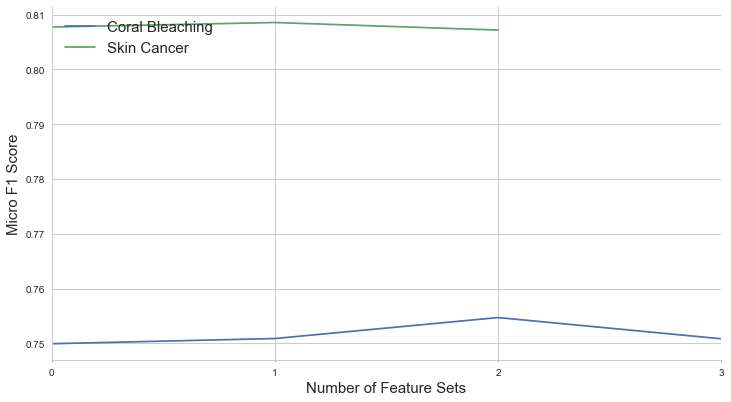

In [17]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

FONT_SIZE = 15

df = by_feat_size

STYLE = "whitegrid"
sns.set_style(STYLE)
sns.set_style(STYLE, {"xtick.major.size": 1})

fig = plt.figure(figsize=(12,6.5))

x = df["count"].values
y_cb = df["micro_f1_score_CB"].values
y_sc = df["micro_f1_score_SC"].values

ax1 = fig.add_subplot(111)
ax1.plot(x,y_cb, label="Coral Bleaching")
ax1.plot(x,y_sc, label="Skin Cancer")

legend = ax1.legend(loc='upper left', shadow=True, fontsize=FONT_SIZE)

ax1.set_xlim([1, 3])
# ax1.set_ylim([0.695, 0.77])
ax1.set_xlabel('Number of Feature Sets', fontsize=FONT_SIZE)
ax1.set_ylabel('Micro F1 Score', fontsize=FONT_SIZE)

plt.xticks(np.arange(min(x), max(x)+1, 1.0), fontsize=10)
sns.despine()

# plt.savefig("/Users/simon.hughes/BitBucket/Dissertation/Dissertation/images/sr_causal_model_parser_f1_score_by_num_feats.png")
plt.show()

## Generate Rows for LaTex Table

### F1 Score As Individual Features are Added

In [18]:
for i, row in df_f1_score_by_feat_size.iterrows():
    #pprint(row)
    
    feats_CB = format_lbl(row["new_feat_CB"])
    micro_f1_score_CB = row["micro_f1_score_CB"]
    
    feats_SC = format_lbl(str(row["new_feat_SC"]))
    if feats_SC == "nan":
        feats_SC = "-"
        
    micro_f1_score_SC = row["micro_f1_score_SC"]
    if str(micro_f1_score_SC) != "nan":
        micro_f1_score_SC = "{0:0.4f}".format(micro_f1_score_SC)
    else:
        micro_f1_score_SC = "-"
    count = row["count"]
    print("{count} & {feat_cb} & {cb_f1:0.4f} & & {feat_sc} & {sc_f1}\\\\"\
          .format(count=count,feat_cb=feats_CB, cb_f1=micro_f1_score_CB,
                  feat_sc=feats_SC, sc_f1=micro_f1_score_SC))

0 & - & 0.7500 & & - & 0.8077\\
1 & Causal Features & 0.7509 & & Concept Code Cnt Features & 0.8086\\
2 & Ratio Features & 0.7547 & & Sentence Position Features & 0.8072\\
3 & Adjacent Sent Code Features & 0.7509 & & - & -\\


## Sanity Check - Do Any Datasets have Duplicate Feature Sets with Different F1 Scores?

In [19]:
#SH: There were some issues with the CB_VD dataset initially for a couple of collections
for df in [cb_td_df, cb_vd_df, sc_td_df, sc_vd_df]:
    gb = group_by(df, bycols=["hs_feats","stemmed"], agg_map=[
        ("micro_f1_score", "count"),
        ("micro_f1_score", "min"),
        ("micro_f1_score", "max"),
    ])
    gb = gb[gb["count(micro_f1_score)"] > 1]
    miss_match = gb[gb["min(micro_f1_score)"] != gb["max(micro_f1_score)"]]
    
    assert len(miss_match) == 0, "Some errors occurred during data capture"

### Compute Reduction in Features

In [20]:
df = cb_vd_df
best_row = df.sort_values("micro_f1_score").tail(1)

max_feats = best_row["count"].values[0]

sub = df[df["count"] == max_feats-1].sort_values("micro_f1_score")
feats = sub.tail(1)["feats"].values[0]
num_feats = sub.tail(1)["num_feats"].values[0]

max_ft_df = (df[df["count"] == max_feats]).copy()
max_ft_df["diff"] = max_ft_df["num_feats"] - num_feats
diffs = max_ft_df["diff"].sum()
total_feats = diffs + num_feats
# diffs, total_feats
act_feats = best_row["num_feats"].values[0]
act_feats, total_feats, act_feats/total_feats

(61652.2, 62551.99999999999, 0.9856151681800742)

In [21]:
df = sc_vd_df
best_row = df.sort_values("micro_f1_score").tail(1)

max_feats = df["count"].max()

sub = df[df["count"] == max_feats-1].sort_values("micro_f1_score")
#feats = sub.tail(1)["feats"].values[0]
num_feats = sub.tail(1)["num_feats"].values[0]

max_ft_df = (df[df["count"] == max_feats]).copy()
max_ft_df["diff"] = max_ft_df["num_feats"] - num_feats
diffs = max_ft_df["diff"].sum()
total_feats = diffs + num_feats
# diffs, total_feats
act_feats = best_row["num_feats"].values[0]
act_feats,total_feats,act_feats/total_feats

(63632.6, 66765.40000000001, 0.9530774922340013)

In [22]:
cb_vd_df[cb_vd_df["stemmed"] == True].sort_values("micro_f1_score", ascending=False).head(1)\
[["count","feats","micro_f1_score","micro_precision","micro_recall"]]

,count,feats,micro_f1_score,micro_precision,micro_recall
0,8,"[single_words, between_word_features, label_se...",0.754731,0.728801,0.782575


In [23]:
cb_vd_df[(cb_vd_df["stemmed"] == True) & (cb_vd_df["count"] == 3)].sort_values("micro_f1_score", ascending=False).head(1)\
[["count","feats","micro_f1_score","micro_precision","micro_recall"]]

,count,feats,micro_f1_score,micro_precision,micro_recall


In [24]:
cb_vd_df[cb_vd_df["stemmed"] == True].sort_values("micro_f1_score", ascending=False).head(1)\
[["count","feats","micro_f1_score","micro_precision","micro_recall"]]

,count,feats,micro_f1_score,micro_precision,micro_recall
0,8,"[single_words, between_word_features, label_se...",0.754731,0.728801,0.782575


In [25]:
sc_vd_df[cb_vd_df["stemmed"] == True].sort_values("micro_f1_score", ascending=False).head(1)\
[["count","feats","micro_f1_score","micro_precision","micro_recall"]]

/Users/simon.hughes/anaconda3/envs/phd_py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,count,feats,micro_f1_score,micro_precision,micro_recall
0,5,"[three_words, between_word_features, size_feat...",0.808573,0.801259,0.816021


In [27]:
sc_vd_df[cb_vd_df["stemmed"] == True].sort_values("micro_f1_score", ascending=False).head(1)\
[["count","feats","micro_f1_score","micro_precision","micro_recall"]]

/Users/simon.hughes/anaconda3/envs/phd_py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,count,feats,micro_f1_score,micro_precision,micro_recall
0,5,"[three_words, between_word_features, size_feat...",0.808573,0.801259,0.816021
